In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights

from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import math
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Data transformations
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])


In [4]:
# Load datasets
train_dataset = datasets.ImageFolder(
    root='/kaggle/input/sapienza-dl2425-challenge/dl2425_challenge_dataset/train', 
    transform=train_transforms
)
val_dataset = datasets.ImageFolder(
    root='/kaggle/input/sapienza-dl2425-challenge/dl2425_challenge_dataset/val', 
    transform=val_transforms
)

In [5]:
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [6]:
# Initialize the model
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.SiLU(),
    nn.Dropout(0.8),        
    nn.Linear(512, 256),
    nn.SiLU(),
    nn.Linear(256, 1)
)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


In [7]:
criterion = nn.BCEWithLogitsLoss()

In [8]:
initial_lr = 1e-5
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [9]:
# Initialize lists to store losses
training_losses = []
validation_losses = []

num_epochs = 20
best_val_loss = float('inf')
best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    training_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

    # Validation step
    model.eval()
    val_running_loss = 0.0
    correct_predictions = 0

    # Initialize lists to store predictions and labels
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.float().unsqueeze(1).to(device)

            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)

            val_running_loss += val_loss.item() * val_images.size(0)

            # Calculate accuracy
            preds = torch.sigmoid(val_outputs) >= 0.5
            correct_predictions += torch.sum(preds == val_labels.byte())

            # Collect predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    val_epoch_loss = val_running_loss / len(val_dataset)
    validation_losses.append(val_epoch_loss)
    val_accuracy = correct_predictions.double() / len(val_dataset)

    # Step the scheduler based on validation loss
    scheduler.step(val_epoch_loss)

    # Print the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    print(f'Current Learning Rate: {current_lr}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        best_val_accuracy = val_accuracy.item()
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved Best Model at Epoch {epoch+1}")

    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch 1/20, Training Loss: 0.5471
Current Learning Rate: 1e-05
Saved Best Model at Epoch 1
Validation Loss: 0.4044, Validation Accuracy: 0.7071
Epoch 2/20, Training Loss: 0.3370
Current Learning Rate: 1e-05
Saved Best Model at Epoch 2
Validation Loss: 0.2300, Validation Accuracy: 0.9471
Epoch 3/20, Training Loss: 0.1906
Current Learning Rate: 1e-05
Saved Best Model at Epoch 3
Validation Loss: 0.1285, Validation Accuracy: 0.9622
Epoch 4/20, Training Loss: 0.1483
Current Learning Rate: 1e-05
Saved Best Model at Epoch 4
Validation Loss: 0.1179, Validation Accuracy: 0.9667
Epoch 5/20, Training Loss: 0.1267
Current Learning Rate: 1e-05
Saved Best Model at Epoch 5
Validation Loss: 0.0838, Validation Accuracy: 0.9756
Epoch 6/20, Training Loss: 0.1144
Current Learning Rate: 1e-05
Validation Loss: 0.0869, Validation Accuracy: 0.9747
Epoch 7/20, Training Loss: 0.1055
Current Learning Rate: 1e-05
Saved Best Model at Epoch 7
Validation Loss: 0.0733, Validation Accuracy: 0.9773
Epoch 8/20, Training

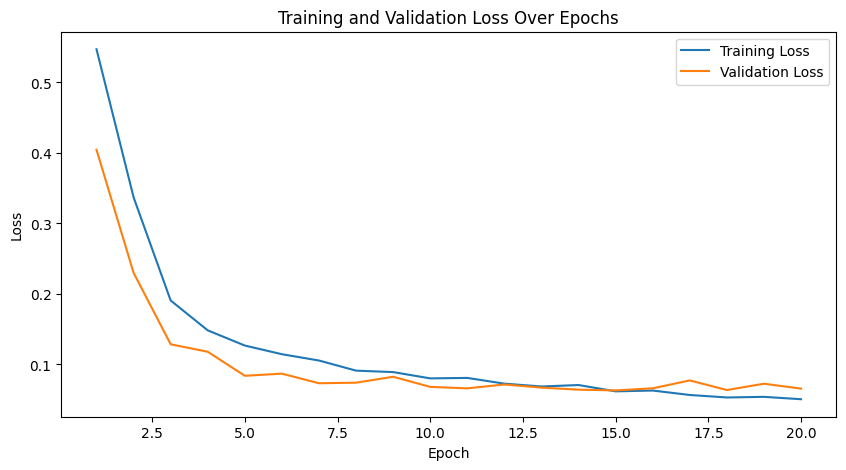

In [10]:
# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

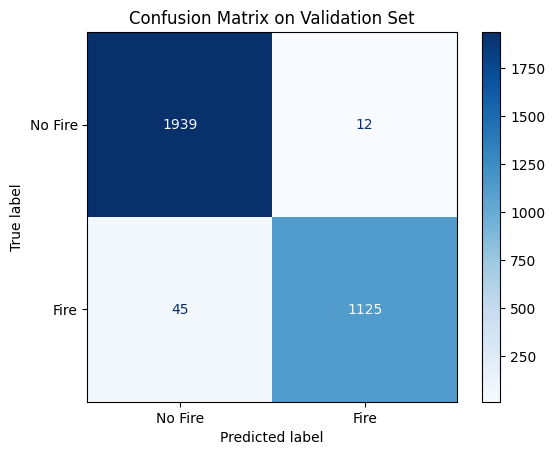

In [11]:
# Generate confusion matrix
# Convert lists to numpy arrays and flatten
all_preds_np = np.array(all_preds).astype(int).flatten()
all_labels_np = np.array(all_labels).astype(int).flatten()

# Compute confusion matrix
cm = confusion_matrix(all_labels_np, all_preds_np)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Fire', 'Fire'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Validation Set')
plt.show()

In [12]:
# Save the best model
torch.save(model.state_dict(), '/kaggle/working/fire_classification_model.pth')